In [146]:
import pandas as pd
from fbprophet import Prophet
import numpy as np
import scipy.optimize as optim
import matplotlib.pyplot as plt

In [16]:
url_cases = 'https://raw.githubusercontent.com/opendemic-org/datascience/master/data/time_series_cases.csv'
url_deaths = 'https://raw.githubusercontent.com/opendemic-org/datascience/master/data/time_series_deaths.csv'
cases = pd.read_csv(url_cases)
deaths = pd.read_csv(url_deaths)
pd.set_option('display.max_columns', None)

In [17]:
# Define funcion with the coefficients to estimate
def func_logistic(t, a, b, c):
    return c / (1 + a * np.exp(-b*t))


In [32]:
def growth(data):
    # countries == county
    countries_processed = 0
    countries_stabilized = 0
    countries_increasing = 0
    countries_list = []
    
    # data is each county in date/case format
    
    
    # Randomly initialize the coefficients
    p0 = np.random.exponential(size=3)
    # Set min bound 0 on all coefficients, and set different max bounds # for each coefficient
    bounds = (0, [100000., 1000., 1000000000.])
    # Convert pd.Series to np.Array and use Scipy's curve fit to find   # the best Nonlinear Least Squares coefficients
    # x = np.array(data['Timestep']) + 1
    x = np.arange(0,len(data)) + 1
    y = np.array(data['Total Cases'])
    
    try:
        (a,b,c),cov = optim.curve_fit(func_logistic, x, y, bounds=bounds, p0=p0, maxfev=1000000)

        # The time step at which the growth is fastest
        t_fastest = np.log(a) / b
        i_fastest = func_logistic(t_fastest, a, b, c)
        
        res_df = data.copy()
        res_df['fastest_grow_day'] = t_fastest
        res_df['fastest_grow_value'] = i_fastest
        res_df['growth_stabilized'] = t_fastest <= x[-1]
        res_df['timestep'] = x
        res_df['res_func_logistic'] = func_logistic(x, a, b, c)
        
        
        if t_fastest <= x[-1]:
            #print('Growth stabilized:', column, '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
            res_df['cap'] = func_logistic(x[-1] + 10, a, b, c)
            countries_stabilized += 1
        else:
            #print('Growth increasing:', column, '| Fastest grow day:', t_fastest, '| Infections:', i_fastest)
            res_df['cap'] = func_logistic(i_fastest + 10, a, b, c)
            countries_increasing += 1
        return(res_df)
    except RuntimeError:
        print('No fit found for: ')
            


In [152]:
def build_model(full_df,df):
    df_ = full_df.copy()
    
    df.columns = ['ds', 'y', 'cap']
    
    m = Prophet(growth="logistic")
    m.fit(df)
    

    future = m.make_future_dataframe(periods=20)
    future['cap'] = df['cap'].iloc[0]

    forecast = m.predict(future)
    
    res_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds').y).reset_index()
    
    res_df['current_date'] = df['ds'].iloc[-1]
    res_df['fastest_growth_day'] = df_['fastest_grow_day'].iloc[-1]
    res_df['growth_stabilized'] = df_['growth_stabilized'].iloc[-1]
    res_df['current_day'] = df_['timestep'].iloc[-1]
    res_df['cap'] = df['cap'].iloc[0]
    return(forecast, res_df)
    
#     res_df.to_csv('data/covid19_forecast_data_' + country + '.csv')
    
#     print('Processed:', country)
    

In [20]:
def simple_plot(df):
    df.columns = ['ds', 'y', 'cap']
    df['ds'] = pd.to_datetime(df['ds'], errors='coerce')
    m.plot(df)

In [21]:
# dict holds key as fips, value is cases by date 
master = {}
for ind,i in cases.iterrows():
    c_df = pd.DataFrame([])
    fip = i['FIPS']
    j = i[cases.columns[10:]].transpose()
    c_df['ds'] = j.index[1:]
    c_df['y'] = j.values[1:]
    master[fip] = c_df
    
# train data will be fips codes 1000 - 2000
# for i in range(1000,2000):
#     if i in master.keys():
#         print(master[i])

In [66]:
# st louis
st = master[29510]
st.columns = ['Timestep', 'Total Cases']

In [73]:
# nyc
nyc = master[36061]
nyc.columns = ['Timestep', 'Total Cases']

In [74]:
st

,Timestep,Total Cases
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0
...,...,...
70,4/1/20,195
71,4/2/20,239
72,4/3/20,239
73,4/4/20,297


In [75]:
nyc

,Timestep,Total Cases
0,1/22/20,0
1,1/23/20,0
2,1/24/20,0
3,1/25/20,0
4,1/26/20,0
...,...,...
70,4/1/20,47439
71,4/2/20,51809
72,4/3/20,57159
73,4/4/20,63306


In [76]:
b = growth(st)
b         

,Timestep,Total Cases,fastest_grow_day,fastest_grow_value,growth_stabilized,timestep,res_func_logistic,cap
0,1/22/20,0,84.265783,590.42647,False,1,0.025199,1180.852941
1,1/23/20,0,84.265783,590.42647,False,2,0.028673,1180.852941
2,1/24/20,0,84.265783,590.42647,False,3,0.032626,1180.852941
3,1/25/20,0,84.265783,590.42647,False,4,0.037124,1180.852941
4,1/26/20,0,84.265783,590.42647,False,5,0.042243,1180.852941
...,...,...,...,...,...,...,...,...
70,4/1/20,195,84.265783,590.42647,False,71,180.334341,1180.852941
71,4/2/20,239,84.265783,590.42647,False,72,200.966711,1180.852941
72,4/3/20,239,84.265783,590.42647,False,73,223.432508,1180.852941
73,4/4/20,297,84.265783,590.42647,False,74,247.774687,1180.852941


In [77]:
c = growth(nyc)
c          

,Timestep,Total Cases,fastest_grow_day,fastest_grow_value,growth_stabilized,timestep,res_func_logistic,cap
0,1/22/20,0,78.917211,94803.433519,False,1,2.193848,189606.867037
1,1/23/20,0,78.917211,94803.433519,False,2,2.538419,189606.867037
2,1/24/20,0,78.917211,94803.433519,False,3,2.937108,189606.867037
3,1/25/20,0,78.917211,94803.433519,False,4,3.398415,189606.867037
4,1/26/20,0,78.917211,94803.433519,False,5,3.932174,189606.867037
...,...,...,...,...,...,...,...,...
70,4/1/20,47439,78.917211,94803.433519,False,71,45425.057491,189606.867037
71,4/2/20,51809,78.917211,94803.433519,False,72,50653.685041,189606.867037
72,4/3/20,57159,78.917211,94803.433519,False,73,56249.357025,189606.867037
73,4/4/20,63306,78.917211,94803.433519,False,74,62186.534374,189606.867037


In [104]:
r

,ds,yhat,yhat_lower,yhat_upper,y,current_date,fastest_growth_day,growth_stabilized,current_day,cap
0,2020-01-22,1.799523,-6.347347,10.054062,0,4/5/20,78.917211,False,75,1180.852941
1,2020-01-23,3.729297,-5.625224,12.374893,0,4/5/20,78.917211,False,75,1180.852941
2,2020-01-24,-0.790577,-9.177588,7.427690,0,4/5/20,78.917211,False,75,1180.852941
3,2020-01-25,0.907183,-7.524962,9.153569,0,4/5/20,78.917211,False,75,1180.852941
4,2020-01-26,-2.041246,-10.134529,6.726789,0,4/5/20,78.917211,False,75,1180.852941
...,...,...,...,...,...,...,...,...,...,...
90,2020-04-21,1092.519624,1084.189318,1101.182978,NaN,4/5/20,78.917211,False,75,1180.852941
91,2020-04-22,1110.783430,1102.236376,1118.052306,NaN,4/5/20,78.917211,False,75,1180.852941
92,2020-04-23,1125.820349,1117.410990,1134.201736,NaN,4/5/20,78.917211,False,75,1180.852941
93,2020-04-24,1132.120526,1122.940996,1140.283937,NaN,4/5/20,78.917211,False,75,1180.852941


In [154]:
p,r = build_model(b,b[['Timestep','Total Cases', 'cap']])
r

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper,y,current_date,fastest_growth_day,growth_stabilized,current_day,cap
0,2020-01-22,1.799523,-6.115818,10.456608,0,4/5/20,84.265783,False,75,1180.852941
1,2020-01-23,3.729297,-4.657012,11.661046,0,4/5/20,84.265783,False,75,1180.852941
2,2020-01-24,-0.790577,-9.219885,7.992126,0,4/5/20,84.265783,False,75,1180.852941
3,2020-01-25,0.907183,-7.062608,9.454655,0,4/5/20,84.265783,False,75,1180.852941
4,2020-01-26,-2.041246,-10.559118,6.198579,0,4/5/20,84.265783,False,75,1180.852941
...,...,...,...,...,...,...,...,...,...,...
90,2020-04-21,1092.519624,1084.240290,1100.467473,NaN,4/5/20,84.265783,False,75,1180.852941
91,2020-04-22,1110.783430,1101.836814,1119.472606,NaN,4/5/20,84.265783,False,75,1180.852941
92,2020-04-23,1125.820349,1118.060919,1134.600830,NaN,4/5/20,84.265783,False,75,1180.852941
93,2020-04-24,1132.120526,1123.630483,1141.022632,NaN,4/5/20,84.265783,False,75,1180.852941


In [155]:
q, w = build_model(c,c[['Timestep','Total Cases', 'cap']])
w

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper,y,current_date,fastest_growth_day,growth_stabilized,current_day,cap
0,2020-01-22,40.430039,-1762.310207,1957.671593,0,4/5/20,78.917211,False,75,189606.867037
1,2020-01-23,66.217460,-2022.080556,1961.143204,0,4/5/20,78.917211,False,75,189606.867037
2,2020-01-24,-26.545321,-2047.271960,1885.482978,0,4/5/20,78.917211,False,75,189606.867037
3,2020-01-25,7.325073,-1878.573138,2158.858741,0,4/5/20,78.917211,False,75,189606.867037
4,2020-01-26,-289.057768,-2147.720311,1787.440281,0,4/5/20,78.917211,False,75,189606.867037
...,...,...,...,...,...,...,...,...,...,...
90,2020-04-21,170194.907714,168255.599821,172339.630188,NaN,4/5/20,78.917211,False,75,189606.867037
91,2020-04-22,172826.771686,170752.050962,174865.278836,NaN,4/5/20,78.917211,False,75,189606.867037
92,2020-04-23,175223.951001,173352.107167,177297.896244,NaN,4/5/20,78.917211,False,75,189606.867037
93,2020-04-24,177192.170235,175268.482341,179187.092044,NaN,4/5/20,78.917211,False,75,189606.867037


In [106]:
q

,ds,trend,cap,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-22,0.555294,189606.867037,-1821.718814,2132.539128,0.555294,0.555294,39.874745,39.874745,39.874745,39.874745,39.874745,39.874745,0.0,0.0,0.0,40.430039
1,2020-01-23,0.655308,189606.867037,-1808.348826,2110.431590,0.655308,0.655308,65.562152,65.562152,65.562152,65.562152,65.562152,65.562152,0.0,0.0,0.0,66.217460
2,2020-01-24,0.773337,189606.867037,-2026.626678,1946.010003,0.773337,0.773337,-27.318658,-27.318658,-27.318658,-27.318658,-27.318658,-27.318658,0.0,0.0,0.0,-26.545321
3,2020-01-25,0.912623,189606.867037,-1809.421018,2121.519545,0.912623,0.912623,6.412450,6.412450,6.412450,6.412450,6.412450,6.412450,0.0,0.0,0.0,7.325073
4,2020-01-26,1.076997,189606.867037,-2405.845904,1682.408541,1.076997,1.076997,-290.134765,-290.134765,-290.134765,-290.134765,-290.134765,-290.134765,0.0,0.0,0.0,-289.057768
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2020-04-21,170069.578168,189606.867037,168347.000456,172209.578063,170069.578089,170069.578248,125.329546,125.329546,125.329546,125.329546,125.329546,125.329546,0.0,0.0,0.0,170194.907714
91,2020-04-22,172786.896941,189606.867037,170823.643646,174831.965314,172786.896865,172786.897018,39.874745,39.874745,39.874745,39.874745,39.874745,39.874745,0.0,0.0,0.0,172826.771686
92,2020-04-23,175158.388850,189606.867037,173152.291847,177099.577277,175158.388777,175158.388923,65.562152,65.562152,65.562152,65.562152,65.562152,65.562152,0.0,0.0,0.0,175223.951001
93,2020-04-24,177219.488893,189606.867037,175204.268450,179119.294258,177219.488824,177219.488962,-27.318658,-27.318658,-27.318658,-27.318658,-27.318658,-27.318658,0.0,0.0,0.0,177192.170235


In [88]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num

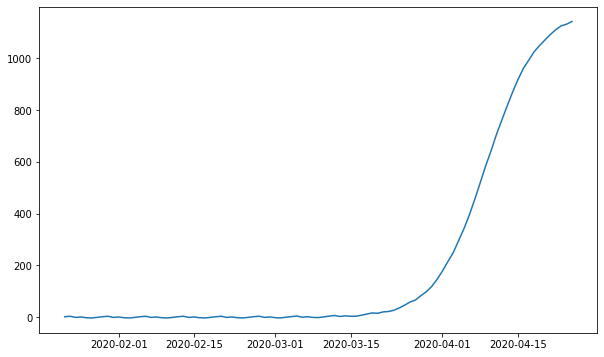

In [114]:
# stl
dates = pd.to_datetime(r["ds"])
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(dates, r['yhat'])

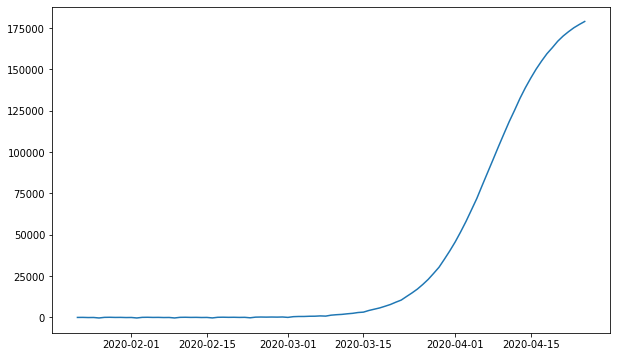

In [115]:
# nyc
dates = pd.to_datetime(w["ds"])
fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(dates, w['yhat'])

TypeError: 'NoneType' object is not subscriptable

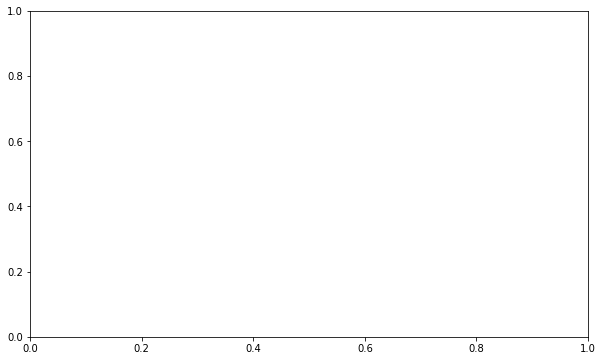

In [116]:
pd.plotting.register_matplotlib_converters()

m = Prophet()
m.plot(q)

In [109]:
# for k,v in master.items():   
#     df = pd.DataFrame({'ds':v.index[1:], 'y':v.values[1:]})
#     print(m.fit(df))

### example

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 86845  100 86845    0     0   316k      0 --:--:-- --:--:-- --:--:--  316k


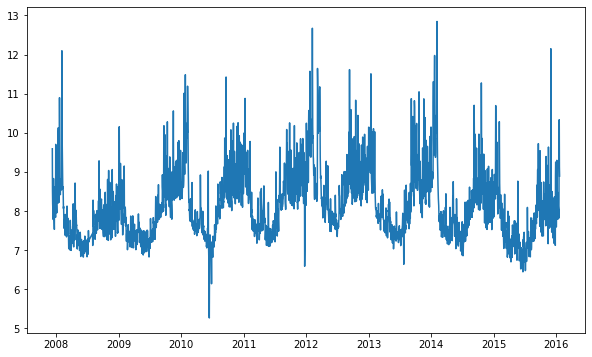

In [143]:

!curl -O https://raw.githubusercontent.com/facebook/prophet/master/examples/example_wp_log_peyton_manning.csv
dat = pd.read_csv("example_wp_log_peyton_manning.csv")
dat["ds"] = pd.to_datetime(dat["ds"])

fig = plt.figure(facecolor='w', figsize=(10, 6))
plt.plot(dat.ds, dat.y)

In [147]:
m = Prophet()
m.fit(dat)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [149]:
future = m.make_future_dataframe(periods=365)
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
3265,2017-01-15,8.206497,7.469083,8.928797
3266,2017-01-16,8.531523,7.799398,9.319173
3267,2017-01-17,8.318930,7.579573,9.076958
3268,2017-01-18,8.151543,7.467725,8.880742
3269,2017-01-19,8.163477,7.437775,8.895687


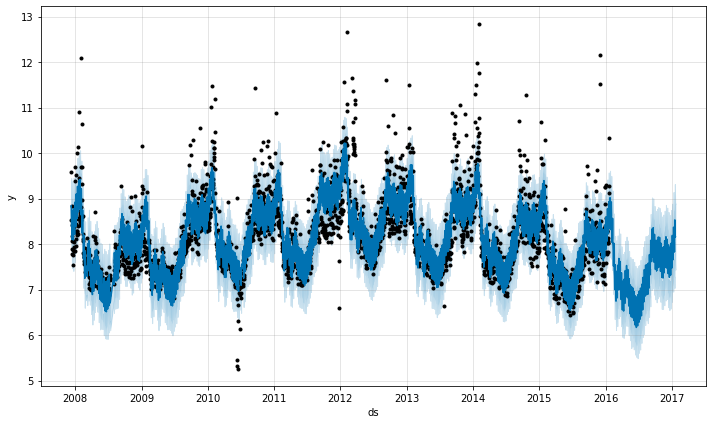

In [150]:
fig1 = m.plot(forecast)

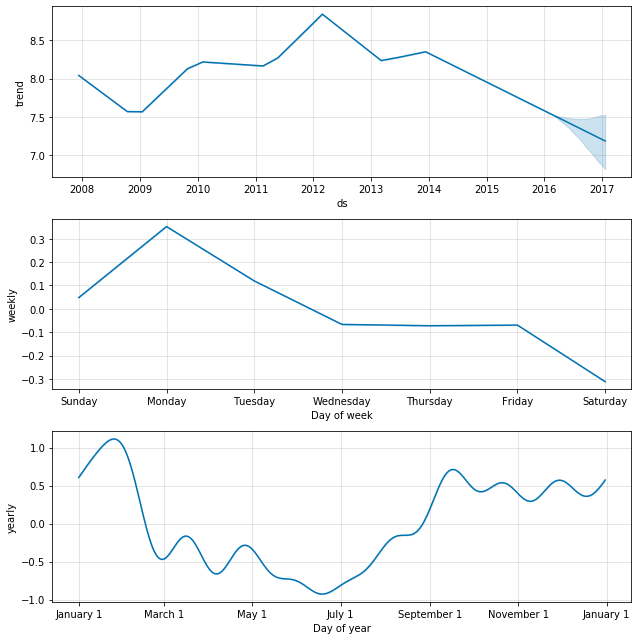

In [151]:
fig2 = m.plot_components(forecast)